# Project - Data Modeling with Apache Cassandra
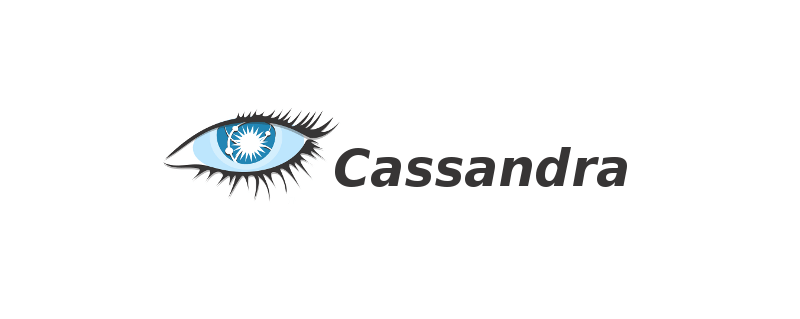

## Project Overview
Built a data model using Apache Cassandra and completed an ETL pipeline in Python for Sparkify, a music streaming startup, to enable analysis of user activity and song play data. Transformed raw log data from CSV files into a structured, query-optimized format by designing denormalized tables tailored to specific analytical queries. The solution supports efficient querying of session history, user behavior, and song popularity by the analytics team.

## Dataset
<p>For this project, the dataset used is event_data, which consists of a directory of CSV files partitioned by date. </p>
<p>Examples of filepaths to two files in the dataset: <br>
event_data/2018-11-01-events.csv<br>
event_data/2018-11-02-events.csv
</p>

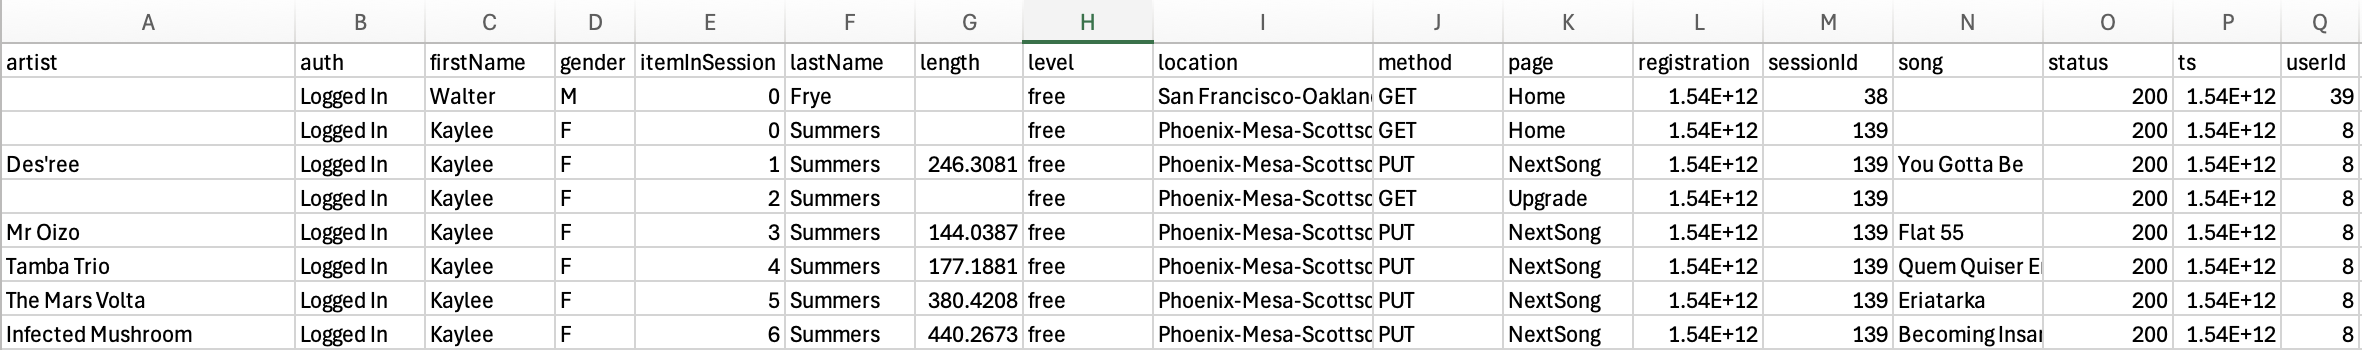

In [1]:
# setting up the enviroment
!pip install cassandra-driver
!pip install pandas

In [2]:
# import the packages
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

## Part I - Build up ETL Pipeline for Pre-Processing the files

To process the original csv data files, we create a list of file paths

In [3]:
# check current working directory
print(os.getcwd())

# Get current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    #print(file_path_list)

/home/jovyan


Extracting and transforming the event_data files to create a new data file csv that will be used for Apache Cassandra tables

In [4]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = []

# for every filepath in the file past list
# read the csv file
# extracting each data row one by one and append it
for f in file_path_list:
    with open(f, 'r', encoding = 'utf8', newline = '') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        next(csvreader)
        # extracting each data row one by one and append it
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line)

# check the total number of rows of the file
#print(len(full_data_rows_list))
# 8056 rows

# check what is the data look like
#print(full_data_rows_list[:3])
#[['Dee Dee Bridgewater', 'Logged In', 'Lily', 'F', '38', 'Koch', 
#'318.64118', 'paid', 'Chicago-Naperville-Elgin, IL-IN-WI', 'PUT', 'NextSong', 
#'1.54105E+12', '818', 'La Vie En Rose', '200', '1.54285E+12','15']]


In [5]:
# create a smaller even data csv file called event_datafile_full csv
# use this file to insert into the Apache Cassandra tables
# we filter out the rows with no artist name
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace = True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline = '') as f:
    writer = csv.writer(f, dialect = 'myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow(((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16])))


In [6]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))
#6821

6821


#### This demonstrates the first five rows of the data
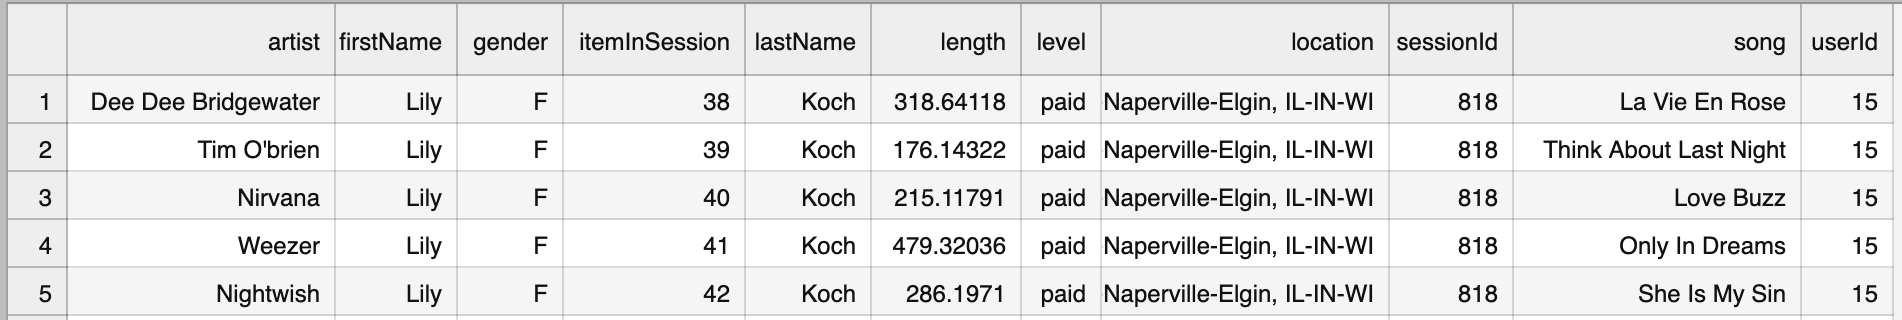

## Part II - Data Modelling with Apache Cassasndra
<p> After processing the data, we have all the event files combined and filtered into a new file called <font color=red> event_datafile_new.csv</font>, located within the work space directory, includes columns <br>
 - artist<br>
 - first name of the user<br>
 - gender of the user<br>
 - item number in session<br>
 - last name of the user<br>
 - length of the song<br>
 - level (paid or free song)<br>
 - location of the user<br>
 - session id<br>
 - song title<br>
 - user ID<br>
</p>

#### Creating a Cluster

<p>Jupyter Notebook and Cassandra were both running in separate Docker containers. To enable communication between them, I created a custom Docker network and connected both containers to it.</p>
docker network create cassandra_net<br>
docker network connect cassandra_net [cassandra docker name]<br>
docker network connect cassandra_net [jupyter notebook docker container name]<br>

In [7]:
from cassandra.cluster import Cluster
cluster = Cluster(['cassandra'])

# To establish connection and begin executing queries, need a session
session = cluster.connect()

#### Creating a key space

In [8]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS sparkify
    WITH REPLICATION = 
    {'class': 'SimpleStrategy', 'replication_factor': 1}""")
except Exception as e:
    print(e)

#### Connect to Keyspace

In [9]:
try:
    session.set_keyspace('sparkify')
except Exception as e:
    print(e)

### Data Modelling
#### When working with NoSQL databases, it’s important to design tables based on the queries you need to support.
For the following three requirements, I will model the data tables accordingly and use CQL to verify the results.
###  1. Query the artist, song title and song's length in the music app history that was heard during  sessionId=338, and itemInSession=4
<p>
    In Cassandra, the <strong>primary key</strong> consists of:<br>
	•	<strong>Partition key</strong>: determines how data is distributed across nodes.<br>
	•	<strong>Clustering key(s)</strong>: determines how data is sorted within a partition.
</p>
<p>We want to look up exactly one row, using sessionId and itemInSession</p>

#### Data modeling, creating the table

In [10]:
query = "CREATE TABLE IF NOT EXISTS music_lib"
query = query + '(sessionId int, itemInSession int, artist text, song text, length float,\
PRIMARY KEY (sessionId, itemInSession))'
try:
    session.execute(query)
except Exception as e:
    print(e)

In [11]:
# injecting the data entries to the Apache Cassandra
file = 'event_datafile_new.csv'

query = 'INSERT INTO music_lib (sessionId, itemInSession, artist, song, length)'
query = query +' VALUES (%s, %s, %s, %s, %s)'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    # skip the header of the file
    next(csvreader)
    for line in csvreader:
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5])))
        

#### SELECT to verify that the data model with the query

In [12]:
query = "SELECT artist, song, length FROM music_lib WHERE sessionId = 338 AND itemInSession = 4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.artist, row.song, row.length)

Faithless Music Matters (Mark Knight Dub) 495.30731201171875


### 2. Query the following: the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid=10, sessionid=182.

#### Data Modelling 
First create a column "name" (first name + last name) by pandas

In [13]:
df = pd.read_csv('event_datafile_new.csv')
df["userName"] = df["firstName"] + " " + df["lastName"]

<strong>Table Design</strong> <br>
1. <strong> Partition Key </strong>: userId (since we’re filtering by userId)
2. <strong> Clustering Key </strong>: sessionId and itemInSession (to ensure sorting by itemInSession within the session)

In [14]:
query = "CREATE TABLE IF NOT EXISTS artist_user"
query = query + ' (userId int, sessionId int, itemInSession int, artist text, song text, userName text,\
PRIMARY KEY ((userId), sessionId, itemInSession))'
try:
    session.execute(query)
except Exception as e:
    print(e)

In [15]:
## injesting the data from the dataframe into the table in Apache Cassandra

query = 'INSERT INTO artist_user (userId, sessionId, itemInSession, artist, song, userName)'
query = query +' VALUES (%s, %s, %s, %s, %s, %s)'

## Loop through the dataframe
for _, row in df.iterrows():
    session.execute(query, (
        row['userId'],
        row['sessionId'],
        row['itemInSession'],
        row['artist'],
        row['song'],
        row['userName']
    ))

#### SELECT to verify that the data model with the query

In [16]:
query = "SELECT artist, song, userName FROM artist_user WHERE userId = 10 AND sessionId = 182"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.artist, row.song, row.username)

Down To The Bone Keep On Keepin' On Sylvie Cruz
Three Drives Greece 2000 Sylvie Cruz
Sebastien Tellier Kilometer Sylvie Cruz
Lonnie Gordon Catch You Baby (Steve Pitron & Max Sanna Radio Edit) Sylvie Cruz


### 3. Query every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

#### Data Modelling 
<strong>Table Design</strong> <br>
1. <strong> Partition Key </strong>: song (since we're filtering by song = 'All Hands Against His Own')
2. <strong> Clustering Key </strong>: userId (To ensure the combination unique to allow multiple users per song)

In [17]:
query = "CREATE TABLE IF NOT EXISTS song_listeners"
query = query + '(userId int, song text, userName text,\
PRIMARY KEY ((song), userId))'
try:
    session.execute(query)
except Exception as e:
    print(e)

In [18]:
## injesting the data from the dataframe into the table in Apache Cassandra

query = 'INSERT INTO song_listeners (userId, song, userName)'
query = query +' VALUES (%s, %s, %s)'

## Loop through the dataframe
for _, row in df.iterrows():
    session.execute(query, (
        row['userId'],
        row['song'],
        row['userName']
    ))

#### SELECT to verify that the data model with the query

In [19]:
query = "SELECT userName FROM song_listeners WHERE song = 'All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.username)

Jacqueline Lynch
Tegan Levine
Sara Johnson


## Clean up

In [20]:
session.execute("DROP TABLE IF EXISTS artist_user")
session.execute("DROP TABLE IF EXISTS song_listeners")
session.execute("DROP TABLE IF EXISTS music_lib")
session.shutdown()
cluster.shutdown()